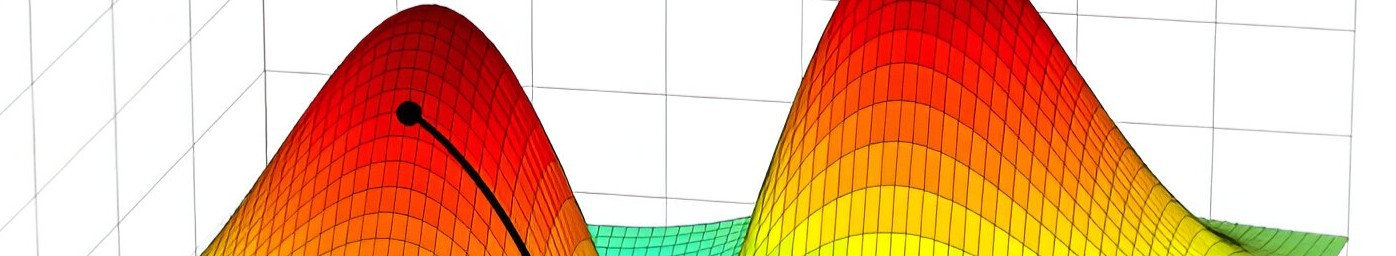

# Solución antigua - Con PYOMO - Caso base, proyecto A caso 2 y caso 3 

En este notebook se ejecutan los caso base y el caso 2 y 3 del proyecto A con el método de Pyomo. Esto se hace para hacer las comparaciones con la metaheurística. Los resultados se guardan en la carpeta "resultados/pyomo".

Es de notar que se utilizó el solver CBC ya que este guarda soluciones parciales, aún así se supere el tiempo límite de ejecución. Esta solución corrige los errores de la entrega 2, y guarda soluciones parciales en caso de que no se logre encontrar una óptima.

## Caso Base:

### Preprocesamiento:

Cargamos los datos del caso base:

In [15]:
# ============================================================
# PREPROCESAMIENTO CASO BASE
# ============================================================

import pandas as pd
import numpy as np
import os
from math import radians, sin, cos, sqrt, atan2

BASE = "cvrp_content-main/caso_base"

# ------------------------------------------------------------
# 1. Cargar archivos 
# ------------------------------------------------------------
clients = pd.read_csv(os.path.join(BASE, "clients.csv"))
depots = pd.read_csv(os.path.join(BASE, "depots.csv"))
vehicles = pd.read_csv(os.path.join(BASE, "vehicles.csv"))

# ------------------------------------------------------------
# 2. Estandarizar índices
# ------------------------------------------------------------
# Clients
clients["StandardizedID"] = clients["ClientID"].apply(lambda x: f"C{int(x):03d}")
clients.set_index("StandardizedID", inplace=True)

# Depot — solo un depósito
depots["StandardizedID"] = depots["DepotID"].apply(lambda x: f"D{int(x):03d}")
depots.set_index("StandardizedID", inplace=True)

# Vehicles
vehicles["StandardizedID"] = vehicles["StandardizedID"].astype(str)
vehicles.set_index("StandardizedID", inplace=True)

# ------------------------------------------------------------
# 3. Eliminar columnas no necesarias
# ------------------------------------------------------------
if "VehicleSizeRestriction" in clients.columns:
    clients.drop(columns=["VehicleSizeRestriction"], inplace=True)

# Ya no usamos capacidad del depósito
if "Capacity" in depots.columns:
    depots.drop(columns=["Capacity"], inplace=True)

# ------------------------------------------------------------
# 4. Parámetros del problema 
# ------------------------------------------------------------
PARAMS = {
    "fuel_price": 16300,
    "fuel_efficiency_typical": 30,
    "C_fixed": 50000,
    "C_dist": 2500,
    "C_time": 7600
}

fuel_efficiency = PARAMS["fuel_efficiency_typical"]

# ------------------------------------------------------------
# 5. Matriz de distancias (Haversine)
# ------------------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Crear matriz de nodos (clientes + único depósito)
nodes = pd.concat([clients, depots])
node_ids = nodes.index.tolist()

dist = pd.DataFrame(index=node_ids, columns=node_ids)
for i in node_ids:
    for j in node_ids:
        dist.loc[i,j] = haversine(
            nodes.loc[i, "Latitude"], nodes.loc[i, "Longitude"],
            nodes.loc[j, "Latitude"], nodes.loc[j, "Longitude"]
        )

# tiempos (velocidad promedio 25 km/h)
time = dist / 25

# ------------------------------------------------------------
# 6. Conjuntos Pyomo
# ------------------------------------------------------------
C = clients.index.tolist()
D = depots.index.tolist()     # solo 1 elemento
N = C + D                     # nodos
K = vehicles.index.tolist()   # vehículos

# ------------------------------------------------------------
# 7. Diccionarios para Pyomo
# ------------------------------------------------------------
dem = clients["Demand"].to_dict()
cap_vehicle = vehicles["Capacity"].to_dict()
range_vehicle = vehicles["Range"].to_dict()

# Una sola efciencia para todos
fuel_eff = {k: fuel_efficiency for k in K}

# Convertir matrices a diccionario
d_matrix = dist.to_dict()
t_matrix = time.to_dict()

cost_fixed = PARAMS["C_fixed"]
cost_dist  = PARAMS["C_dist"]
cost_time  = PARAMS["C_time"]
fuel_price = PARAMS["fuel_price"]

# ------------------------------------------------------------
# 8. Impresión de verificación
# ------------------------------------------------------------

print("\n==================== CLIENTES ====================")
print("Shape:", clients.shape)
display(clients)

print("\n==================== DEPÓSITO ÚNICO ====================")
print("Shape:", depots.shape)
display(depots)

print("\n==================== VEHÍCULOS ====================")
print("Shape:", vehicles.shape)
display(vehicles)

print("\n==================== PARÁMETROS ====================")
for k,v in PARAMS.items():
    print(k, "=", v)

print("\n==================== CONJUNTOS ====================")
print("Clientes C:", C)
print("Depósito D:", D)
print("Nodos N:", N)
print("Vehículos K:", K)

print("\n==================== MATRIZ DE DISTANCIAS (primeras filas) ====================")
display(dist.iloc[:10,:10])

print("\n==================== MATRIZ DE TIEMPOS (primeras filas) ====================")
display(time.iloc[:10,:10])

print("\n=== Preprocesamiento simple COMPLETADO ===")



==================== CLIENTES ====================
Shape: (24, 5)


,ClientID,LocationID,Latitude,Longitude,Demand
StandardizedID,,,,,
C001,1,2,4.597954,-74.098938,13
C002,2,3,4.687821,-74.075571,15
C003,3,4,4.709494,-74.107085,12
C004,4,5,4.605029,-74.097280,15
C005,5,6,4.648464,-74.164641,20
C006,6,7,4.662137,-74.120838,17
C007,7,8,4.697499,-74.022131,17
C008,8,9,4.649417,-74.172075,20
C009,9,10,4.606311,-74.156153,20



==================== DEPÓSITO ÚNICO ====================
Shape: (1, 4)


,DepotID,LocationID,Longitude,Latitude
StandardizedID,,,,
D001,1,1,-74.153536,4.743359



==================== VEHÍCULOS ====================
Shape: (8, 3)


,VehicleID,Capacity,Range
StandardizedID,,,
V001,1,130,170
V002,2,140,200
V003,3,120,180
V004,4,100,90
V005,5,70,100
V006,6,55,170
V007,7,110,150
V008,8,114,140



==================== PARÁMETROS ====================
fuel_price = 16300
fuel_efficiency_typical = 30
C_fixed = 50000
C_dist = 2500
C_time = 7600

==================== CONJUNTOS ====================
Clientes C: ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017', 'C018', 'C019', 'C020', 'C021', 'C022', 'C023', 'C024']
Depósito D: ['D001']
Nodos N: ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017', 'C018', 'C019', 'C020', 'C021', 'C022', 'C023', 'C024', 'D001']
Vehículos K: ['V001', 'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008']

==================== MATRIZ DE DISTANCIAS (primeras filas) ====================


,C001,C002,C003,C004,C005,C006,C007,C008,C009,C010
C001,0.0,10.322815,12.435524,0.807864,9.196379,7.538292,13.963605,9.922386,6.409175,4.609612
C002,10.322815,0.0,4.24327,9.515205,10.79791,5.772628,6.019354,11.516199,12.724237,14.597335
C003,12.435524,4.24327,0.0,11.666745,9.313469,5.481995,9.50871,9.823578,12.696992,17.01504
C004,0.807864,9.515205,11.666745,0.0,8.891891,6.865994,13.232156,9.647906,6.526787,5.352778
C005,9.196379,10.79791,9.313469,8.891891,0.0,5.087179,16.708478,0.830692,4.780719,13.048684
C006,7.538292,5.772628,5.481995,6.865994,5.087179,0.0,11.624368,5.852062,7.338533,12.126862
C007,13.963605,6.019354,9.50871,13.232156,16.708478,11.624368,0.0,17.456562,17.984389,17.321204
C008,9.922386,11.516199,9.823578,9.647906,0.830692,5.852062,17.456562,0.0,5.107754,13.662458
C009,6.409175,12.724237,12.696992,6.526787,4.780719,7.338533,17.984389,5.107754,0.0,9.093918
C010,4.609612,14.597335,17.01504,5.352778,13.048684,12.126862,17.321204,13.662458,9.093918,0.0



==================== MATRIZ DE TIEMPOS (primeras filas) ====================


,C001,C002,C003,C004,C005,C006,C007,C008,C009,C010
C001,0.0,0.412913,0.497421,0.032315,0.367855,0.301532,0.558544,0.396895,0.256367,0.184384
C002,0.412913,0.0,0.169731,0.380608,0.431916,0.230905,0.240774,0.460648,0.508969,0.583893
C003,0.497421,0.169731,0.0,0.46667,0.372539,0.21928,0.380348,0.392943,0.50788,0.680602
C004,0.032315,0.380608,0.46667,0.0,0.355676,0.27464,0.529286,0.385916,0.261071,0.214111
C005,0.367855,0.431916,0.372539,0.355676,0.0,0.203487,0.668339,0.033228,0.191229,0.521947
C006,0.301532,0.230905,0.21928,0.27464,0.203487,0.0,0.464975,0.234082,0.293541,0.485074
C007,0.558544,0.240774,0.380348,0.529286,0.668339,0.464975,0.0,0.698262,0.719376,0.692848
C008,0.396895,0.460648,0.392943,0.385916,0.033228,0.234082,0.698262,0.0,0.20431,0.546498
C009,0.256367,0.508969,0.50788,0.261071,0.191229,0.293541,0.719376,0.20431,0.0,0.363757
C010,0.184384,0.583893,0.680602,0.214111,0.521947,0.485074,0.692848,0.546498,0.363757,0.0



=== Preprocesamiento simple COMPLETADO ===


Ahora, implementamos el modelo en pyomo, y guardamos los resultados, para hacer comparaciones posteriormente. Este modelo específico para el caso base, no implementa la restricción de rango, ya que si se aplica, el modelo no encuentra ninguna solución.

In [13]:

# ============================================================
# IMPLEMENTACIÓN PYOMO
# ============================================================

import pyomo.environ as pyo
import pandas as pd
import time, threading, os, csv, sys

# monitoreo opcional de memoria
try:
    import psutil
    _psutil_ok = True
    _proc = psutil.Process()
except Exception:
    _psutil_ok = False
    _proc = None

# funciones auxiliares
def progress(msg):
    print(msg, flush=True)

def mem_info_mb():
    if _psutil_ok and _proc is not None:
        return _proc.memory_info().rss / (1024*1024)
    return None

def safe_value(var):
    try:
        return pyo.value(var)
    except Exception:
        return None

# construccion del modelo con la misma estructura de antes
def build_model():
    progress("=== Construyendo modelo Pyomo simplificado (CBC) ===")

    model = pyo.ConcreteModel()

    # conjuntos desde el preprocesamiento
    model.C = pyo.Set(initialize=C)
    model.D = pyo.Set(initialize=D)
    model.N = pyo.Set(initialize=N)
    model.K = pyo.Set(initialize=K)

    # arcos permitidos: todos i!=j excluyendo deposito->deposito
    Pairs = []
    for i in N:
        for j in N:
            if (i != j) and not (i in D and j in D):
                Pairs.append((i, j))
    model.Pairs = pyo.Set(initialize=Pairs, dimen=2)
    progress(f"Arcos permitidos: {len(Pairs)}")

    # parametros del modelo
    model.dem = pyo.Param(model.C, initialize=dem, within=pyo.NonNegativeReals)
    model.cap = pyo.Param(model.K, initialize=cap_vehicle)
    model.range = pyo.Param(model.K, initialize=range_vehicle)

    # matrices de distancia y tiempo usando callables
    def _dist(m,i,j):
        return float(d_matrix[i][j])
    model.dist = pyo.Param(model.N, model.N, initialize=_dist)

    def _time(m,i,j):
        return float(t_matrix[i][j])
    model.time = pyo.Param(model.N, model.N, initialize=_time)

    # costos y combustible
    model.cost_fixed = pyo.Param(initialize=cost_fixed)
    model.cost_dist  = pyo.Param(initialize=cost_dist)
    model.cost_time  = pyo.Param(initialize=cost_time)
    model.fuel_price = pyo.Param(initialize=fuel_price)
    model.fuel_eff = pyo.Param(model.K, initialize=fuel_eff)

    progress("Parametros Pyomo creados...")

    # variables de decision
    model.x = pyo.Var(model.Pairs, model.K, domain=pyo.Binary)
    model.y = pyo.Var(model.K, domain=pyo.Binary)
    model.u = pyo.Var(model.C, bounds=(1, len(C)))   # posiciones MTZ

    progress("Variables creadas...")

    # restricciones del modelo
    def visit_rule(m,c):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c for k in m.K) == 1
    model.visit = pyo.Constraint(model.C, rule=visit_rule)

    def flow_rule(m,c,k):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) - sum(m.x[c,j,k] for (i,j) in m.Pairs if i==c) == 0
    model.flow = pyo.Constraint(model.C, model.K, rule=flow_rule)

    def dep_out_rule(m,k):
        return sum(m.x[d,j,k] for d in m.D for (i,j) in m.Pairs if i==d) <= 1
    model.depot_out = pyo.Constraint(model.K, rule=dep_out_rule)

    def dep_in_rule(m,k):
        return sum(m.x[i,d,k] for d in m.D for (i,j) in m.Pairs if j==d) <= 1
    model.depot_in = pyo.Constraint(model.K, rule=dep_in_rule)

    def cap_rule(m,k):
        return sum(m.dem[c] * sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) for c in m.C) <= m.cap[k]
    model.capacity = pyo.Constraint(model.K, rule=cap_rule)

    def range_rule(m,k):
        return sum(m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs) <= m.range[k]
    #model.range_constr = pyo.Constraint(model.K, rule=range_rule)

    BIGM = len(C)
    def activate_rule(m,k):
        return sum(m.x[i,j,k] for (i,j) in m.Pairs) <= BIGM * m.y[k]
    model.bigM_activation = pyo.Constraint(model.K, rule=activate_rule)

    def mtz_rule(m,i,j,k):
        if i in m.C and j in m.C and i != j:
            return m.u[i] + 1 <= m.u[j] + BIGM * (1 - m.x[i,j,k])
        return pyo.Constraint.Skip
    model.mtz = pyo.Constraint(model.Pairs, model.K, rule=mtz_rule)

    progress("Restricciones creadas...")

    # funcion objetivo: minimizar distancia + tiempo + combustible + fijo
    def obj_rule(m):
        return (
            sum(m.cost_fixed * m.y[k] for k in m.K)
            + sum(m.cost_dist * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum(m.cost_time * m.time[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum((m.fuel_price / m.fuel_eff[k]) * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
        )
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    progress("Objetivo OK. Modelo listo.")
    return model

# resolver con CBC mostrando progreso de tiempo y memoria
def solve_with_cbc(model, timelimit=2400, poll_sec=5):
    progress("=== Ejecutando CBC ===")
    solver = pyo.SolverFactory("cbc")
    # en CBC se usa la opcion seconds para el limite de tiempo
    try:
        solver.options['seconds'] = int(timelimit)
    except Exception:
        # si falla usamos el parametro timelimit de pyomo
        pass

    results_container = {"res": None, "err": None}

    def _solve():
        try:
            # load_solutions y keepfiles en True para que pyomo lea la solucion si CBC la produce
            results_container["res"] = solver.solve(model, tee=True, load_solutions=True, keepfiles=True, timelimit=timelimit)
        except Exception as e:
            results_container["err"] = e

    thread = threading.Thread(target=_solve, daemon=True)
    thread.start()

    start = time.time()
    last_mem = None
    while thread.is_alive():
        elapsed = time.time() - start
        mem = mem_info_mb()
        if mem is not None:
            if last_mem is None or abs(mem - last_mem) > 1.0:
                progress(f"Tiempo transcurrido: {int(elapsed)}s - Memoria RSS: {mem:.1f} MB")
                last_mem = mem
            else:
                progress(f"Tiempo transcurrido: {int(elapsed)}s")
        else:
            progress(f"Tiempo transcurrido: {int(elapsed)}s")
        time.sleep(poll_sec)

    # el thread termino
    if results_container["err"] is not None:
        progress(f"ERROR ejecutando solver: {results_container['err']}")
    else:
        progress("Solver CBC finalizo sin excepcion.")
    return results_container["res"], results_container["err"]


# extraer arcos usados con valor >= threshold de forma segura
def extract_arcs_from_model(model, threshold=0.5):
    used = []
    for (i,j) in model.Pairs:
        for k in model.K:
            try:
                v = model.x[i,j,k].value
            except Exception:
                v = None
            if v is not None and v > threshold:
                used.append((i,j,k,float(v)))
    return used

# reconstruir rutas desde los arcos en orden deterministico
def reconstruct_routes_from_arcs(used_arcs):
    # construir diccionario de sucesores por vehiculo
    succ_by_k = {}
    for (i,j,k,v) in used_arcs:
        succ_by_k.setdefault(k, {})[i] = j

    # reconstruir rutas
    routes = {}
    DEPOT = D[0]
    for k in K:
        succ = succ_by_k.get(k, {})
        if not succ:
            routes[k] = []
            continue
        # empezar en el deposito si tiene salida, sino en la primera llave
        start = DEPOT if DEPOT in succ else next(iter(succ.keys()))
        route = [start]
        cur = start
        visited = set()
        while cur in succ:
            nxt = succ[cur]
            route.append(nxt)
            if nxt == start:
                break
            if nxt in visited:
                # ciclo detectado, parar
                break
            visited.add(nxt)
            cur = nxt
            if len(route) > len(N) + 5:
                break
        routes[k] = route
    return routes

# validaciones y escritura del CSV
def postprocess_and_save(model, results, used_arcs, routes, out_dir="results/Proyecto_A_Caso2", csv_filename=None):
    from pyomo.opt import TerminationCondition

    # determinar si tenemos algo utilizable
    usable = False
    try:
        term = results.solver.termination_condition
        stat = results.solver.status
        progress(f"Solver status: {stat}, termination: {term}")
        if term in (TerminationCondition.optimal, TerminationCondition.feasible, getattr(TerminationCondition,'maxTimeLimit', None)):
            usable = True
    except Exception:
        # si no se puede leer results, revisar si el modelo tiene valores
        pass

    # si el modelo tiene algunos valores x > 0, podemos proceder
    has_values = any(( (model.x[i,j,k].value is not None and model.x[i,j,k].value > 0.0) for (i,j) in model.Pairs for k in model.K ))
    if has_values:
        usable = True

    if not usable:
        progress("No hay solucion usable. No se hara postproceso.")
        return False

    # conjuntos para conveniencia
    Cset = list(C)
    Dset = list(D)
    Kset = list(K)
    DEPOT = Dset[0]

    # ya tenemos las rutas reconstruidas

    # imprimir rutas
    progress("\n=== RUTAS RECONSTRUIDAS ===")
    for k, r in routes.items():
        if not r:
            progress(f"Vehiculo {k}: (no asignado)")
        else:
            progress(f"Vehiculo {k}: {'-'.join(r)}")

    # validaciones
    progress("\n=== VALIDACIONES ===")
    # demanda por vehiculo
    dem_by_vehicle = {}
    for k, r in routes.items():
        s = 0.0
        for node in r:
            if node in Cset:
                s += dem[node]
        dem_by_vehicle[k] = s

    # revisar capacidad
    cap_viol = False
    for k in Kset:
        if dem_by_vehicle.get(k,0.0) > cap_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} demanda {dem_by_vehicle[k]} > capacidad {cap_vehicle[k]}")
            cap_viol = True
    if not cap_viol:
        progress("OK: capacidad OK")

    # rango y tiempo
    dist_by_vehicle = {}
    time_by_vehicle = {}
    range_viol = False
    for k, r in routes.items():
        dsum = 0.0
        tsum = 0.0
        if len(r) >= 2:
            for idx in range(len(r)-1):
                p = r[idx]; q = r[idx+1]
                dsum += float(d_matrix[p][q])
                tsum += float(t_matrix[p][q])
        dist_by_vehicle[k] = dsum
        time_by_vehicle[k] = tsum
        if dsum > range_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} distancia {dsum} > rango {range_vehicle[k]}")
            range_viol = True
    if not range_viol:
        progress("OK: rango OK")

    # cobertura de clientes
    seen = []
    for k, r in routes.items():
        seen.extend([n for n in r if n in Cset])
    missing = [c for c in Cset if seen.count(c) != 1]
    if len(missing) == 0:
        progress("OK: cobertura OK")
    else:
        progress("[ERROR] cobertura: clientes con problema (cliente: veces):")
        for c in Cset:
            cnt = seen.count(c)
            if cnt != 1:
                progress(f"  {c}: {cnt}")

    # escribir archivo CSV
    os.makedirs(out_dir, exist_ok=True)
    
    # preguntar nombre del archivo si no se proporciono
    if csv_filename is None:
        try:
            csv_filename = input("Ingresa el nombre del archivo CSV (sin extension .csv): ").strip()
            if not csv_filename:
                csv_filename = "verificacion_caso_simple"
                progress(f"No se ingreso nombre, usando por defecto: {csv_filename}")
        except Exception:
            csv_filename = "verificacion_caso_simple"
            progress(f"Error leyendo entrada, usando nombre por defecto: {csv_filename}")
    
    # asegurar que termine en .csv
    if not csv_filename.endswith('.csv'):
        csv_filename = csv_filename + '.csv'
    
    out_path = os.path.join(out_dir, csv_filename)
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["VehicleId","DepotId","InitialLoad","RouteSequence","ClientsServed","DemandsSatisfied","TotalDistance","TotalTime","FuelCost"])
        for k in Kset:
            yv = safe_value(model.y[k])
            if yv is None or yv < 0.5:
                continue
            r = routes.get(k, [])
            if not r:
                continue
            clients_served = [n for n in r if n in Cset]
            demands = [dem[n] for n in clients_served]
            dtotal = dist_by_vehicle.get(k,0.0)
            ttotal = time_by_vehicle.get(k,0.0)
            fe_k = fuel_eff.get(k, fuel_eff[next(iter(fuel_eff))]) if isinstance(fuel_eff, dict) else fuel_eff
            fuelc = (dtotal / fe_k) * fuel_price if fe_k and fe_k > 0 else 0.0

            writer.writerow([k, DEPOT, dem_by_vehicle.get(k,0.0), "-".join(r), "-".join(clients_served), "-".join(str(x) for x in demands), round(dtotal,6), round(ttotal,6), round(fuelc,6)])

    progress(f"\nCSV guardado en: {out_path}")
    return True

# ============================================================
# POSTPROCESAMIENTO CASO BASE
# ============================================================


# ejecucion principal: construir, resolver con CBC, extraer, reconstruir y postprocesar
TIMELIMIT = 2400   # segundos
POLL_SEC = 5       # frecuencia de actualizacion del progreso

model = build_model()
results, err = solve_with_cbc(model, timelimit=TIMELIMIT, poll_sec=POLL_SEC)

# si el solver retorno un objeto results, intentar extraer arcos; sino intentar leer las variables del modelo de todos modos
if results is not None:
    used_arcs = extract_arcs_from_model(model, threshold=0.5)
else:
    # incluso si results es None, intentar extraer lo que exista con threshold menor
    used_arcs = extract_arcs_from_model(model, threshold=0.01)

routes = reconstruct_routes_from_arcs(used_arcs)

ok = postprocess_and_save(model, results, used_arcs, routes, "resultados/pyomo/caso_base", "verificacion_caso_base")

if ok:
    progress("=== POSTPROCESO COMPLETADO ===")
else:
    progress("=== POSTPROCESO NO COMPLETADO: no hay solucion usable ===")

=== Construyendo modelo Pyomo simplificado (CBC) ===
Arcos permitidos: 600
Parametros Pyomo creados...
Variables creadas...
Restricciones creadas...
Objetivo OK. Modelo listo.
=== Ejecutando CBC ===
Tiempo transcurrido: 0s - Memoria RSS: 70.0 MB
Solver log file: 'C:\Users\mauri\AppData\Local\Temp\tmpxykhiev6.cbc.log'
Solver solution file: 'C:\Users\mauri\AppData\Local\Temp\tmpmpzo45or.pyomo.soln'
Solver problem files: ('C:\\Users\\mauri\\AppData\\Local\\Temp\\tmpmpzo45or.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Jul 31 2025 

command line - C:\ProgramData\anaconda3\envs\pyomo_env\Library\bin\cbc.exe -sec 2400 -timeMode elapsed -seconds 2400 -printingOptions all -import C:\Users\mauri\AppData\Local\Temp\tmpmpzo45or.pyomo.lp -stat=1 -solve -solu C:\Users\mauri\AppData\Local\Temp\tmpmpzo45or.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 2400
Option for timeMode changed from cpu to elapsed
seconds was changed from 2400 to 2400
Option for

## Proyecto A - Caso 2:

### Preprocesamiento:

Cargamos los datos del caso 2 del proyecto A, ignorando los datos que no necesitamos:

In [2]:
import pandas as pd
import numpy as np
import os
from math import radians, sin, cos, sqrt, atan2

# ============================================================
# PREPROCESAMIENTO PROYECTO A - CASO 2
# ============================================================


BASE = "cvrp_content-main/caso_2"

# ------------------------------------------------------------
# 1. Cargar archivos 
# ------------------------------------------------------------
clients = pd.read_csv(os.path.join(BASE, "clients.csv"))
depots = pd.read_csv(os.path.join(BASE, "depots.csv"))
vehicles = pd.read_csv(os.path.join(BASE, "vehicles.csv"))

# ------------------------------------------------------------
# 2. Estandarizar índices
# ------------------------------------------------------------
# Clients
clients["StandardizedID"] = clients["ClientID"].apply(lambda x: f"C{int(x):03d}")
clients.set_index("StandardizedID", inplace=True)

# Depot — solo un depósito
depots["StandardizedID"] = depots["DepotID"].apply(lambda x: f"D{int(x):03d}")
depots.set_index("StandardizedID", inplace=True)

# Vehicles
vehicles["StandardizedID"] = vehicles["StandardizedID"].astype(str)
vehicles.set_index("StandardizedID", inplace=True)

# ------------------------------------------------------------
# 3. Eliminar columnas no necesarias
# ------------------------------------------------------------
if "VehicleSizeRestriction" in clients.columns:
    clients.drop(columns=["VehicleSizeRestriction"], inplace=True)

# Ya no usamos capacidad del depósito
if "Capacity" in depots.columns:
    depots.drop(columns=["Capacity"], inplace=True)

# ------------------------------------------------------------
# 4. Parmetros del problema 
# ------------------------------------------------------------
PARAMS = {
    "fuel_price": 16300,
    "fuel_efficiency_typical": 30,
    "C_fixed": 50000,
    "C_dist": 2500,
    "C_time": 7600
}

fuel_efficiency = PARAMS["fuel_efficiency_typical"]

# ------------------------------------------------------------
# 5. Matriz de distancias (Haversine)
# ------------------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Crear matriz de nodos (clientes + único depósito)
nodes = pd.concat([clients, depots])
node_ids = nodes.index.tolist()

dist = pd.DataFrame(index=node_ids, columns=node_ids)
for i in node_ids:
    for j in node_ids:
        dist.loc[i,j] = haversine(
            nodes.loc[i, "Latitude"], nodes.loc[i, "Longitude"],
            nodes.loc[j, "Latitude"], nodes.loc[j, "Longitude"]
        )

# tiempos (velocidad promedio 25 km/h)
time = dist / 25

# ------------------------------------------------------------
# 6. Conjuntos Pyomo
# ------------------------------------------------------------
C = clients.index.tolist()
D = depots.index.tolist()     # solo 1 elemento
N = C + D                     # nodos
K = vehicles.index.tolist()   # vehículos

# ------------------------------------------------------------
# 7. Diccionarios para Pyomo
# ------------------------------------------------------------
dem = clients["Demand"].to_dict()
cap_vehicle = vehicles["Capacity"].to_dict()
range_vehicle = vehicles["Range"].to_dict()

# Una sola eficiencia para todos
fuel_eff = {k: fuel_efficiency for k in K}

# Convertir matrices a diccionario
d_matrix = dist.to_dict()
t_matrix = time.to_dict()

cost_fixed = PARAMS["C_fixed"]
cost_dist  = PARAMS["C_dist"]
cost_time  = PARAMS["C_time"]
fuel_price = PARAMS["fuel_price"]

# ------------------------------------------------------------
# 8. Impresión de verifcación
# ------------------------------------------------------------

print("\n==================== CLIENTES ====================")
print("Shape:", clients.shape)
display(clients)

print("\n==================== DEPÓSITO ÚNICO ====================")
print("Shape:", depots.shape)
display(depots)

print("\n==================== VEHÍCULOS ====================")
print("Shape:", vehicles.shape)
display(vehicles)

print("\n==================== PARÁMETROS ====================")
for k,v in PARAMS.items():
    print(k, "=", v)

print("\n==================== CONJUNTOS ====================")
print("Clientes C:", C)
print("Depósito D:", D)
print("Nodos N:", N)
print("Vehículos K:", K)

print("\n==================== MATRIZ DE DISTANCIAS (primeras filas) ====================")
display(dist.iloc[:10,:10])

print("\n==================== MATRIZ DE TIEMPOS (primeras filas) ====================")
display(time.iloc[:10,:10])

print("\n=== Preprocesamiento simple COMPLETADO ===")



==================== CLIENTES ====================
Shape: (9, 5)


,ClientID,LocationID,Latitude,Longitude,Demand
StandardizedID,,,,,
C001,1,13,4.632553,-74.196992,12
C002,2,14,4.601328,-74.155037,15
C003,3,15,4.732421,-74.101787,15
C004,4,16,4.638612,-74.194862,6
C005,5,17,4.727692,-74.110272,5
C006,6,18,4.665003,-74.152289,11
C007,7,19,4.677102,-74.032411,12
C008,8,20,4.707007,-74.062476,10
C009,9,21,4.636075,-74.098042,15



==================== DEPÓSITO ÚNICO ====================
Shape: (1, 4)


,DepotID,LocationID,Longitude,Latitude
StandardizedID,,,,
D001,1,1,-74.153536,4.743359



==================== VEHÍCULOS ====================
Shape: (6, 4)


,VehicleID,VehicleType,Capacity,Range
StandardizedID,,,,
V001,1,small van,131.921140,145.852071
V002,2,medium van,108.435620,1304.605971
V003,3,medium van,91.504255,953.172609
V004,4,light truck,32.896064,17.302304
V005,5,medium van,22.652628,16.627680
V006,6,light truck,22.682912,13.602811



==================== PARÁMETROS ====================
fuel_price = 16300
fuel_efficiency_typical = 30
C_fixed = 50000
C_dist = 2500
C_time = 7600

==================== CONJUNTOS ====================
Clientes C: ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009']
Depósito D: ['D001']
Nodos N: ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'D001']
Vehículos K: ['V001', 'V002', 'V003', 'V004', 'V005', 'V006']

==================== MATRIZ DE DISTANCIAS (primeras filas) ====================


,C001,C002,C003,C004,C005,C006,C007,C008,C009,D001
C001,0.0,5.803284,15.317946,0.713914,14.292583,6.129034,18.900896,17.0524,10.973774,13.228833
C002,5.803284,0.0,15.72614,6.055671,14.901069,7.086848,15.990567,15.598665,7.404834,15.793978
C003,15.317946,15.72614,0.0,14.669824,1.077357,9.35529,9.846219,5.192696,10.72128,5.862088
C004,0.713914,6.055671,14.669824,0.0,13.637994,5.556399,18.505822,16.525708,10.73442,12.515397
C005,14.292583,14.901069,1.077357,13.637994,0.0,8.38285,10.300416,5.774552,10.277131,5.100985
C006,6.129034,7.086848,9.35529,5.556399,8.38285,0.0,13.353572,10.994805,6.818641,8.713893
C007,18.900896,15.990567,9.846219,18.505822,10.300416,13.353572,0.0,4.707356,8.585989,15.311998
C008,17.0524,15.598665,5.192696,16.525708,5.774552,10.994805,4.707356,0.0,8.81738,10.870488
C009,10.973774,7.404834,10.72128,10.73442,10.277131,6.818641,8.585989,8.81738,0.0,13.421456
D001,13.228833,15.793978,5.862088,12.515397,5.100985,8.713893,15.311998,10.870488,13.421456,0.0



==================== MATRIZ DE TIEMPOS (primeras filas) ====================


,C001,C002,C003,C004,C005,C006,C007,C008,C009,D001
C001,0.0,0.232131,0.612718,0.028557,0.571703,0.245161,0.756036,0.682096,0.438951,0.529153
C002,0.232131,0.0,0.629046,0.242227,0.596043,0.283474,0.639623,0.623947,0.296193,0.631759
C003,0.612718,0.629046,0.0,0.586793,0.043094,0.374212,0.393849,0.207708,0.428851,0.234484
C004,0.028557,0.242227,0.586793,0.0,0.54552,0.222256,0.740233,0.661028,0.429377,0.500616
C005,0.571703,0.596043,0.043094,0.54552,0.0,0.335314,0.412017,0.230982,0.411085,0.204039
C006,0.245161,0.283474,0.374212,0.222256,0.335314,0.0,0.534143,0.439792,0.272746,0.348556
C007,0.756036,0.639623,0.393849,0.740233,0.412017,0.534143,0.0,0.188294,0.34344,0.61248
C008,0.682096,0.623947,0.207708,0.661028,0.230982,0.439792,0.188294,0.0,0.352695,0.43482
C009,0.438951,0.296193,0.428851,0.429377,0.411085,0.272746,0.34344,0.352695,0.0,0.536858
D001,0.529153,0.631759,0.234484,0.500616,0.204039,0.348556,0.61248,0.43482,0.536858,0.0



=== Preprocesamiento simple COMPLETADO ===


Ahora, implementamos el modelo en pyomo, y guardamos los resultados, para hacer comparaciones posteriormente. Esta solución sí toma en cuenta todas las restricciones, y es la misma que se utiliza para el caso 3 del proyecto A.

In [3]:
import pyomo.environ as pyo
import pandas as pd
import time, threading, os, csv, sys

# monitoreo opcional de memoria
try:
    import psutil
    _psutil_ok = True
    _proc = psutil.Process()
except Exception:
    _psutil_ok = False
    _proc = None

# funciones auxiliares
def progress(msg):
    print(msg, flush=True)

def mem_info_mb():
    if _psutil_ok and _proc is not None:
        return _proc.memory_info().rss / (1024*1024)
    return None

def safe_value(var):
    try:
        return pyo.value(var)
    except Exception:
        return None

# construccion del modelo con la misma estructura de antes
def build_model():
    progress("=== Construyendo modelo Pyomo simplificado (CBC) ===")

    model = pyo.ConcreteModel()

    # conjuntos desde el preprocesamiento
    model.C = pyo.Set(initialize=C)
    model.D = pyo.Set(initialize=D)
    model.N = pyo.Set(initialize=N)
    model.K = pyo.Set(initialize=K)

    # arcos permitidos: todos i!=j excluyendo deposito->deposito
    Pairs = []
    for i in N:
        for j in N:
            if (i != j) and not (i in D and j in D):
                Pairs.append((i, j))
    model.Pairs = pyo.Set(initialize=Pairs, dimen=2)
    progress(f"Arcos permitidos: {len(Pairs)}")

    # parametros del modelo
    model.dem = pyo.Param(model.C, initialize=dem, within=pyo.NonNegativeReals)
    model.cap = pyo.Param(model.K, initialize=cap_vehicle)
    model.range = pyo.Param(model.K, initialize=range_vehicle)

    # matrices de distancia y tiempo usando callables
    def _dist(m,i,j):
        return float(d_matrix[i][j])
    model.dist = pyo.Param(model.N, model.N, initialize=_dist)

    def _time(m,i,j):
        return float(t_matrix[i][j])
    model.time = pyo.Param(model.N, model.N, initialize=_time)

    # costos y combustible
    model.cost_fixed = pyo.Param(initialize=cost_fixed)
    model.cost_dist  = pyo.Param(initialize=cost_dist)
    model.cost_time  = pyo.Param(initialize=cost_time)
    model.fuel_price = pyo.Param(initialize=fuel_price)
    model.fuel_eff = pyo.Param(model.K, initialize=fuel_eff)

    progress("Parametros Pyomo creados...")

    # variables de decision
    model.x = pyo.Var(model.Pairs, model.K, domain=pyo.Binary)
    model.y = pyo.Var(model.K, domain=pyo.Binary)
    model.u = pyo.Var(model.C, bounds=(1, len(C)))   # posiciones MTZ

    progress("Variables creadas...")

    # restricciones del modelo
    def visit_rule(m,c):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c for k in m.K) == 1
    model.visit = pyo.Constraint(model.C, rule=visit_rule)

    def flow_rule(m,c,k):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) - sum(m.x[c,j,k] for (i,j) in m.Pairs if i==c) == 0
    model.flow = pyo.Constraint(model.C, model.K, rule=flow_rule)

    def dep_out_rule(m,k):
        return sum(m.x[d,j,k] for d in m.D for (i,j) in m.Pairs if i==d) <= 1
    model.depot_out = pyo.Constraint(model.K, rule=dep_out_rule)

    def dep_in_rule(m,k):
        return sum(m.x[i,d,k] for d in m.D for (i,j) in m.Pairs if j==d) <= 1
    model.depot_in = pyo.Constraint(model.K, rule=dep_in_rule)

    def cap_rule(m,k):
        return sum(m.dem[c] * sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) for c in m.C) <= m.cap[k]
    model.capacity = pyo.Constraint(model.K, rule=cap_rule)

    def range_rule(m,k):
        return sum(m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs) <= m.range[k]
    model.range_constr = pyo.Constraint(model.K, rule=range_rule)

    BIGM = len(C)
    def activate_rule(m,k):
        return sum(m.x[i,j,k] for (i,j) in m.Pairs) <= BIGM * m.y[k]
    model.bigM_activation = pyo.Constraint(model.K, rule=activate_rule)

    def mtz_rule(m,i,j,k):
        if i in m.C and j in m.C and i != j:
            return m.u[i] + 1 <= m.u[j] + BIGM * (1 - m.x[i,j,k])
        return pyo.Constraint.Skip
    model.mtz = pyo.Constraint(model.Pairs, model.K, rule=mtz_rule)

    progress("Restricciones creadas...")

    # funcion objetivo: minimizar distancia + tiempo + combustible + fijo
    def obj_rule(m):
        return (
            sum(m.cost_fixed * m.y[k] for k in m.K)
            + sum(m.cost_dist * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum(m.cost_time * m.time[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum((m.fuel_price / m.fuel_eff[k]) * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
        )
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    progress("Objetivo OK. Modelo listo.")
    return model

# resolver con CBC mostrando progreso de tiempo y memoria
def solve_with_cbc(model, timelimit=2400, poll_sec=5):
    progress("=== Ejecutando CBC ===")
    solver = pyo.SolverFactory("cbc")
    # en CBC se usa la opcion seconds para el limite de tiempo
    try:
        solver.options['seconds'] = int(timelimit)
    except Exception:
        # si falla usamos el parametro timelimit de pyomo
        pass

    results_container = {"res": None, "err": None}

    def _solve():
        try:
            # load_solutions y keepfiles en True para que pyomo lea la solucion si CBC la produce
            results_container["res"] = solver.solve(model, tee=True, load_solutions=True, keepfiles=True, timelimit=timelimit)
        except Exception as e:
            results_container["err"] = e

    thread = threading.Thread(target=_solve, daemon=True)
    thread.start()

    start = time.time()
    last_mem = None
    while thread.is_alive():
        elapsed = time.time() - start
        mem = mem_info_mb()
        if mem is not None:
            if last_mem is None or abs(mem - last_mem) > 1.0:
                progress(f"Tiempo transcurrido: {int(elapsed)}s - Memoria RSS: {mem:.1f} MB")
                last_mem = mem
            else:
                progress(f"Tiempo transcurrido: {int(elapsed)}s")
        else:
            progress(f"Tiempo transcurrido: {int(elapsed)}s")
        time.sleep(poll_sec)

    # el thread termino
    if results_container["err"] is not None:
        progress(f"ERROR ejecutando solver: {results_container['err']}")
    else:
        progress("Solver CBC finalizo sin excepcion.")
    return results_container["res"], results_container["err"]


# extraer arcos usados con valor >= threshold de forma segura
def extract_arcs_from_model(model, threshold=0.5):
    used = []
    for (i,j) in model.Pairs:
        for k in model.K:
            try:
                v = model.x[i,j,k].value
            except Exception:
                v = None
            if v is not None and v > threshold:
                used.append((i,j,k,float(v)))
    return used

# reconstruir rutas desde los arcos en orden deterministico
def reconstruct_routes_from_arcs(used_arcs):
    # construir diccionario de sucesores por vehiculo
    succ_by_k = {}
    for (i,j,k,v) in used_arcs:
        succ_by_k.setdefault(k, {})[i] = j

    # reconstruir rutas
    routes = {}
    DEPOT = D[0]
    for k in K:
        succ = succ_by_k.get(k, {})
        if not succ:
            routes[k] = []
            continue
        # empezar en el deposito si tiene salida, sino en la primera llave
        start = DEPOT if DEPOT in succ else next(iter(succ.keys()))
        route = [start]
        cur = start
        visited = set()
        while cur in succ:
            nxt = succ[cur]
            route.append(nxt)
            if nxt == start:
                break
            if nxt in visited:
                # ciclo detectado, parar
                break
            visited.add(nxt)
            cur = nxt
            if len(route) > len(N) + 5:
                break
        routes[k] = route
    return routes

# validaciones y escritura del CSV
def postprocess_and_save(model, results, used_arcs, routes, out_dir="results/Proyecto_A_Caso2", csv_filename=None):
    from pyomo.opt import TerminationCondition

    # determinar si tenemos algo utilizable
    usable = False
    try:
        term = results.solver.termination_condition
        stat = results.solver.status
        progress(f"Solver status: {stat}, termination: {term}")
        if term in (TerminationCondition.optimal, TerminationCondition.feasible, getattr(TerminationCondition,'maxTimeLimit', None)):
            usable = True
    except Exception:
        # si no se puede leer results, revisar si el modelo tiene valores
        pass

    # si el modelo tiene algunos valores x > 0, podemos proceder
    has_values = any(( (model.x[i,j,k].value is not None and model.x[i,j,k].value > 0.0) for (i,j) in model.Pairs for k in model.K ))
    if has_values:
        usable = True

    if not usable:
        progress("No hay solucion usable. No se hara postproceso.")
        return False

    # conjuntos para conveniencia
    Cset = list(C)
    Dset = list(D)
    Kset = list(K)
    DEPOT = Dset[0]

    # ya tenemos las rutas reconstruidas

    # imprimir rutas
    progress("\n=== RUTAS RECONSTRUIDAS ===")
    for k, r in routes.items():
        if not r:
            progress(f"Vehiculo {k}: (no asignado)")
        else:
            progress(f"Vehiculo {k}: {'-'.join(r)}")

    # validaciones
    progress("\n=== VALIDACIONES ===")
    # demanda por vehiculo
    dem_by_vehicle = {}
    for k, r in routes.items():
        s = 0.0
        for node in r:
            if node in Cset:
                s += dem[node]
        dem_by_vehicle[k] = s

    # revisar capacidad
    cap_viol = False
    for k in Kset:
        if dem_by_vehicle.get(k,0.0) > cap_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} demanda {dem_by_vehicle[k]} > capacidad {cap_vehicle[k]}")
            cap_viol = True
    if not cap_viol:
        progress("OK: capacidad OK")

    # rango y tiempo
    dist_by_vehicle = {}
    time_by_vehicle = {}
    range_viol = False
    for k, r in routes.items():
        dsum = 0.0
        tsum = 0.0
        if len(r) >= 2:
            for idx in range(len(r)-1):
                p = r[idx]; q = r[idx+1]
                dsum += float(d_matrix[p][q])
                tsum += float(t_matrix[p][q])
        dist_by_vehicle[k] = dsum
        time_by_vehicle[k] = tsum
        if dsum > range_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} distancia {dsum} > rango {range_vehicle[k]}")
            range_viol = True
    if not range_viol:
        progress("OK: rango OK")

    # cobertura de clientes
    seen = []
    for k, r in routes.items():
        seen.extend([n for n in r if n in Cset])
    missing = [c for c in Cset if seen.count(c) != 1]
    if len(missing) == 0:
        progress("OK: cobertura OK")
    else:
        progress("[ERROR] cobertura: clientes con problema (cliente: veces):")
        for c in Cset:
            cnt = seen.count(c)
            if cnt != 1:
                progress(f"  {c}: {cnt}")

    # escribir archivo CSV
    os.makedirs(out_dir, exist_ok=True)
    
    # preguntar nombre del archivo si no se proporciono
    if csv_filename is None:
        try:
            csv_filename = input("Ingresa el nombre del archivo CSV (sin extension .csv): ").strip()
            if not csv_filename:
                csv_filename = "verificacion_caso_simple"
                progress(f"No se ingreso nombre, usando por defecto: {csv_filename}")
        except Exception:
            csv_filename = "verificacion_caso_simple"
            progress(f"Error leyendo entrada, usando nombre por defecto: {csv_filename}")
    
    # asegurar que termine en .csv
    if not csv_filename.endswith('.csv'):
        csv_filename = csv_filename + '.csv'
    
    out_path = os.path.join(out_dir, csv_filename)
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["VehicleId","DepotId","InitialLoad","RouteSequence","ClientsServed","DemandsSatisfied","TotalDistance","TotalTime","FuelCost"])
        for k in Kset:
            yv = safe_value(model.y[k])
            if yv is None or yv < 0.5:
                continue
            r = routes.get(k, [])
            if not r:
                continue
            clients_served = [n for n in r if n in Cset]
            demands = [dem[n] for n in clients_served]
            dtotal = dist_by_vehicle.get(k,0.0)
            ttotal = time_by_vehicle.get(k,0.0)
            fe_k = fuel_eff.get(k, fuel_eff[next(iter(fuel_eff))]) if isinstance(fuel_eff, dict) else fuel_eff
            fuelc = (dtotal / fe_k) * fuel_price if fe_k and fe_k > 0 else 0.0

            writer.writerow([k, DEPOT, dem_by_vehicle.get(k,0.0), "-".join(r), "-".join(clients_served), "-".join(str(x) for x in demands), round(dtotal,6), round(ttotal,6), round(fuelc,6)])

    progress(f"\nCSV guardado en: {out_path}")
    return True


# ejecucion principal: construir, resolver con CBC, extraer, reconstruir y postprocesar
TIMELIMIT = 600   # segundos
POLL_SEC = 5       # frecuencia de actualizacion del progreso

model = build_model()
results, err = solve_with_cbc(model, timelimit=TIMELIMIT, poll_sec=POLL_SEC)

# si el solver retorno un objeto results, intentar extraer arcos; sino intentar leer las variables del modelo de todos modos
if results is not None:
    used_arcs = extract_arcs_from_model(model, threshold=0.5)
else:
    # incluso si results es None, intentar extraer lo que exista con threshold menor
    used_arcs = extract_arcs_from_model(model, threshold=0.01)

routes = reconstruct_routes_from_arcs(used_arcs)

ok = postprocess_and_save(model, results, used_arcs, routes, "resultados/pyomo", "verificacion_caso_2")

if ok:
    progress("=== POSTPROCESO COMPLETADO ===")
else:
    progress("=== POSTPROCESO NO COMPLETADO: no hay solucion usable ===")

=== Construyendo modelo Pyomo simplificado (CBC) ===
Arcos permitidos: 90
Parametros Pyomo creados...
Variables creadas...
Restricciones creadas...
Objetivo OK. Modelo listo.
=== Ejecutando CBC ===
Tiempo transcurrido: 0s - Memoria RSS: 141.8 MB
Solver log file: 'C:\Users\mauri\AppData\Local\Temp\tmpjph_ufco.cbc.log'
Solver solution file: 'C:\Users\mauri\AppData\Local\Temp\tmpui4oc6u1.pyomo.soln'
Solver problem files: ('C:\\Users\\mauri\\AppData\\Local\\Temp\\tmpui4oc6u1.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Jul 31 2025 

command line - C:\ProgramData\anaconda3\envs\pyomo_env\Library\bin\cbc.exe -sec 600 -timeMode elapsed -seconds 600 -printingOptions all -import C:\Users\mauri\AppData\Local\Temp\tmpui4oc6u1.pyomo.lp -stat=1 -solve -solu C:\Users\mauri\AppData\Local\Temp\tmpui4oc6u1.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
seconds was changed from 600 to 600
Option for prin

## Proyecto A - Caso 3:

### Preprocesamiento:

Cargamos los datos del caso 3 del proyecto A, ignorando los datos que no necesitamos:

In [2]:
# ============================================================
# PREPROCESAMIENTO PROYECTO A - CASO 3 
# ============================================================

import pandas as pd
import numpy as np
import os
from math import radians, sin, cos, sqrt, atan2

BASE = "cvrp_content-main/caso_3"

# ------------------------------------------------------------
# 1. Cargar archivos 
# ------------------------------------------------------------
clients = pd.read_csv(os.path.join(BASE, "clients.csv"))
depots = pd.read_csv(os.path.join(BASE, "depots.csv"))
vehicles = pd.read_csv(os.path.join(BASE, "vehicles.csv"))

# ------------------------------------------------------------
# 2. Estandarizar índices
# ------------------------------------------------------------
# Clients
clients["StandardizedID"] = clients["ClientID"].apply(lambda x: f"C{int(x):03d}")
clients.set_index("StandardizedID", inplace=True)

# Depot — solo un depósito
depots["StandardizedID"] = depots["DepotID"].apply(lambda x: f"D{int(x):03d}")
depots.set_index("StandardizedID", inplace=True)

# Vehicles
vehicles["StandardizedID"] = vehicles["StandardizedID"].astype(str)
vehicles.set_index("StandardizedID", inplace=True)

# ------------------------------------------------------------
# 3. Eliminar columnas no necesarias
# ------------------------------------------------------------
if "VehicleSizeRestriction" in clients.columns:
    clients.drop(columns=["VehicleSizeRestriction"], inplace=True)

# Ya no usamos capacidad del depósito
if "Capacity" in depots.columns:
    depots.drop(columns=["Capacity"], inplace=True)

# ------------------------------------------------------------
# 4. Parámetros del problema 
# ------------------------------------------------------------
PARAMS = {
    "fuel_price": 16300,
    "fuel_efficiency_typical": 30,
    "C_fixed": 50000,
    "C_dist": 2500,
    "C_time": 7600
}

fuel_efficiency = PARAMS["fuel_efficiency_typical"]

# ------------------------------------------------------------
# 5. Matriz de distncias (Haversine)
# ------------------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Crear matriz de nodos (clientes + único depósito)
nodes = pd.concat([clients, depots])
node_ids = nodes.index.tolist()

dist = pd.DataFrame(index=node_ids, columns=node_ids)
for i in node_ids:
    for j in node_ids:
        dist.loc[i,j] = haversine(
            nodes.loc[i, "Latitude"], nodes.loc[i, "Longitude"],
            nodes.loc[j, "Latitude"], nodes.loc[j, "Longitude"]
        )

# tiempos (velocidad promedio 25 km/h)
time = dist / 25

# ------------------------------------------------------------
# 6. Conjuntos Pyomo
# ------------------------------------------------------------
C = clients.index.tolist()
D = depots.index.tolist()     # solo 1 elemento
N = C + D                     # nodos
K = vehicles.index.tolist()   # vehículos

# ------------------------------------------------------------
# 7. Diccionarios para Pyomo
# ------------------------------------------------------------
dem = clients["Demand"].to_dict()
cap_vehicle = vehicles["Capacity"].to_dict()
range_vehicle = vehicles["Range"].to_dict()

# Una sola eficiencia para todos
fuel_eff = {k: fuel_efficiency for k in K}

# Convertir matrices a diccionario
d_matrix = dist.to_dict()
t_matrix = time.to_dict()

cost_fixed = PARAMS["C_fixed"]
cost_dist  = PARAMS["C_dist"]
cost_time  = PARAMS["C_time"]
fuel_price = PARAMS["fuel_price"]

# ------------------------------------------------------------
# 8. Impresión de verificación
# ------------------------------------------------------------

print("\n==================== CLIENTES ====================")
print("Shape:", clients.shape)
display(clients)

print("\n==================== DEPÓSITO ÚNICO ====================")
print("Shape:", depots.shape)
display(depots)

print("\n==================== VEHÍCULOS ====================")
print("Shape:", vehicles.shape)
display(vehicles)

print("\n==================== PARÁMETROS ====================")
for k,v in PARAMS.items():
    print(k, "=", v)

print("\n==================== CONJUNTOS ====================")
print("Clientes C:", C)
print("Depósito D:", D)
print("Nodos N:", N)
print("Vehículos K:", K)

print("\n==================== MATRIZ DE DISTANCIAS (primeras filas) ====================")
display(dist.iloc[:10,:10])

print("\n==================== MATRIZ DE TIEMPOS (primeras filas) ====================")
display(time.iloc[:10,:10])

print("\n=== Preprocesamiento simple COMPLETADO ===")



==================== CLIENTES ====================
Shape: (90, 5)


,ClientID,LocationID,Demand,Longitude,Latitude
StandardizedID,,,,,
C001,1,12,13,-74.150806,4.679769
C002,2,13,15,-74.017996,4.733831
C003,3,14,16,-74.143655,4.620928
C004,4,15,22,-74.034583,4.733074
C005,5,16,14,-74.055887,4.820900
...,...,...,...,...,...
C086,86,97,19,-74.075137,4.547407
C087,87,98,10,-74.162648,4.659240
C088,88,99,12,-74.147008,4.564126



==================== DEPÓSITO ÚNICO ====================
Shape: (1, 4)


,DepotID,LocationID,Longitude,Latitude
StandardizedID,,,,
D001,1,1,-74.153536,4.743359



==================== VEHÍCULOS ====================
Shape: (45, 4)


,VehicleID,Capacity,Range,VehicleType
StandardizedID,,,,
V001,1,132,146,light truck
V002,2,136,196,medium van
V003,3,115,143,light truck
V004,4,158,174,medium van
V005,5,109,167,medium van
V006,6,109,137,light truck
V007,7,126,93,light truck
V008,8,79,134,small van
V009,9,96,160,medium van



==================== PARÁMETROS ====================
fuel_price = 16300
fuel_efficiency_typical = 30
C_fixed = 50000
C_dist = 2500
C_time = 7600

==================== CONJUNTOS ====================
Clientes C: ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017', 'C018', 'C019', 'C020', 'C021', 'C022', 'C023', 'C024', 'C025', 'C026', 'C027', 'C028', 'C029', 'C030', 'C031', 'C032', 'C033', 'C034', 'C035', 'C036', 'C037', 'C038', 'C039', 'C040', 'C041', 'C042', 'C043', 'C044', 'C045', 'C046', 'C047', 'C048', 'C049', 'C050', 'C051', 'C052', 'C053', 'C054', 'C055', 'C056', 'C057', 'C058', 'C059', 'C060', 'C061', 'C062', 'C063', 'C064', 'C065', 'C066', 'C067', 'C068', 'C069', 'C070', 'C071', 'C072', 'C073', 'C074', 'C075', 'C076', 'C077', 'C078', 'C079', 'C080', 'C081', 'C082', 'C083', 'C084', 'C085', 'C086', 'C087', 'C088', 'C089', 'C090']
Depósito D: ['D001']
Nodos N: ['C001', 'C002', 'C003', 'C004', 'C005

,C001,C002,C003,C004,C005,C006,C007,C008,C009,C010
C001,0.0,15.898281,6.590642,14.178224,18.891907,16.013847,10.710491,14.287776,8.026749,9.772516
C002,15.898281,0.0,18.749529,1.839996,10.552877,5.94966,5.301682,25.796897,8.623967,9.465018
C003,6.590642,18.749529,0.0,17.367191,24.270003,20.647744,14.377286,7.960639,12.879765,9.920823
C004,14.178224,1.839996,17.367191,0.0,10.047101,5.299922,3.503037,24.630568,6.787024,8.528717
C005,18.891907,10.552877,24.270003,10.047101,0.0,4.747878,10.871353,32.163359,11.393479,17.654623
C006,16.013847,5.94966,20.647744,5.299922,4.747878,0.0,6.524486,28.372215,8.017817,13.153806
C007,10.710491,5.301682,14.377286,3.503037,10.871353,6.524486,0.0,21.946234,3.421297,6.802322
C008,14.287776,25.796897,7.960639,24.630568,32.163359,28.372215,21.946234,0.0,20.773266,16.398642
C009,8.026749,8.623967,12.879765,6.787024,11.393479,8.017817,3.421297,20.773266,0.0,7.903306
C010,9.772516,9.465018,9.920823,8.528717,17.654623,13.153806,6.802322,16.398642,7.903306,0.0



==================== MATRIZ DE TIEMPOS (primeras filas) ====================


,C001,C002,C003,C004,C005,C006,C007,C008,C009,C010
C001,0.0,0.635931,0.263626,0.567129,0.755676,0.640554,0.42842,0.571511,0.32107,0.390901
C002,0.635931,0.0,0.749981,0.0736,0.422115,0.237986,0.212067,1.031876,0.344959,0.378601
C003,0.263626,0.749981,0.0,0.694688,0.9708,0.82591,0.575091,0.318426,0.515191,0.396833
C004,0.567129,0.0736,0.694688,0.0,0.401884,0.211997,0.140121,0.985223,0.271481,0.341149
C005,0.755676,0.422115,0.9708,0.401884,0.0,0.189915,0.434854,1.286534,0.455739,0.706185
C006,0.640554,0.237986,0.82591,0.211997,0.189915,0.0,0.260979,1.134889,0.320713,0.526152
C007,0.42842,0.212067,0.575091,0.140121,0.434854,0.260979,0.0,0.877849,0.136852,0.272093
C008,0.571511,1.031876,0.318426,0.985223,1.286534,1.134889,0.877849,0.0,0.830931,0.655946
C009,0.32107,0.344959,0.515191,0.271481,0.455739,0.320713,0.136852,0.830931,0.0,0.316132
C010,0.390901,0.378601,0.396833,0.341149,0.706185,0.526152,0.272093,0.655946,0.316132,0.0



=== Preprocesamiento simple COMPLETADO ===


Ahora, ejecutamos el modelo en pyomo, y guardamos los resultados, para hacer comparaciones posteriormente:

In [3]:
import pyomo.environ as pyo
import pandas as pd
import time, threading, os, csv, sys

# monitoreo opcional de memoria
try:
    import psutil
    _psutil_ok = True
    _proc = psutil.Process()
except Exception:
    _psutil_ok = False
    _proc = None

# funciones auxiliares
def progress(msg):
    print(msg, flush=True)

def mem_info_mb():
    if _psutil_ok and _proc is not None:
        return _proc.memory_info().rss / (1024*1024)
    return None

def safe_value(var):
    try:
        return pyo.value(var)
    except Exception:
        return None

# construccion del modelo con la misma estructura de antes
def build_model():
    progress("=== Construyendo modelo Pyomo simplificado (CBC) ===")

    model = pyo.ConcreteModel()

    # conjuntos desde el preprocesamiento
    model.C = pyo.Set(initialize=C)
    model.D = pyo.Set(initialize=D)
    model.N = pyo.Set(initialize=N)
    model.K = pyo.Set(initialize=K)

    # arcos permitidos: todos i!=j excluyendo deposito->deposito
    Pairs = []
    for i in N:
        for j in N:
            if (i != j) and not (i in D and j in D):
                Pairs.append((i, j))
    model.Pairs = pyo.Set(initialize=Pairs, dimen=2)
    progress(f"Arcos permitidos: {len(Pairs)}")

    # parametros del modelo
    model.dem = pyo.Param(model.C, initialize=dem, within=pyo.NonNegativeReals)
    model.cap = pyo.Param(model.K, initialize=cap_vehicle)
    model.range = pyo.Param(model.K, initialize=range_vehicle)

    # matrices de distancia y tiempo usando callables
    def _dist(m,i,j):
        return float(d_matrix[i][j])
    model.dist = pyo.Param(model.N, model.N, initialize=_dist)

    def _time(m,i,j):
        return float(t_matrix[i][j])
    model.time = pyo.Param(model.N, model.N, initialize=_time)

    # costos y combustible
    model.cost_fixed = pyo.Param(initialize=cost_fixed)
    model.cost_dist  = pyo.Param(initialize=cost_dist)
    model.cost_time  = pyo.Param(initialize=cost_time)
    model.fuel_price = pyo.Param(initialize=fuel_price)
    model.fuel_eff = pyo.Param(model.K, initialize=fuel_eff)

    progress("Parametros Pyomo creados...")

    # variables de decision
    model.x = pyo.Var(model.Pairs, model.K, domain=pyo.Binary)
    model.y = pyo.Var(model.K, domain=pyo.Binary)
    model.u = pyo.Var(model.C, bounds=(1, len(C)))   # posiciones MTZ

    progress("Variables creadas...")

    # restricciones del modelo
    def visit_rule(m,c):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c for k in m.K) == 1
    model.visit = pyo.Constraint(model.C, rule=visit_rule)

    def flow_rule(m,c,k):
        return sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) - sum(m.x[c,j,k] for (i,j) in m.Pairs if i==c) == 0
    model.flow = pyo.Constraint(model.C, model.K, rule=flow_rule)

    def dep_out_rule(m,k):
        return sum(m.x[d,j,k] for d in m.D for (i,j) in m.Pairs if i==d) <= 1
    model.depot_out = pyo.Constraint(model.K, rule=dep_out_rule)

    def dep_in_rule(m,k):
        return sum(m.x[i,d,k] for d in m.D for (i,j) in m.Pairs if j==d) <= 1
    model.depot_in = pyo.Constraint(model.K, rule=dep_in_rule)

    def cap_rule(m,k):
        return sum(m.dem[c] * sum(m.x[i,c,k] for (i,j) in m.Pairs if j==c) for c in m.C) <= m.cap[k]
    model.capacity = pyo.Constraint(model.K, rule=cap_rule)

    def range_rule(m,k):
        return sum(m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs) <= m.range[k]
    model.range_constr = pyo.Constraint(model.K, rule=range_rule)

    BIGM = len(C)
    def activate_rule(m,k):
        return sum(m.x[i,j,k] for (i,j) in m.Pairs) <= BIGM * m.y[k]
    model.bigM_activation = pyo.Constraint(model.K, rule=activate_rule)

    def mtz_rule(m,i,j,k):
        if i in m.C and j in m.C and i != j:
            return m.u[i] + 1 <= m.u[j] + BIGM * (1 - m.x[i,j,k])
        return pyo.Constraint.Skip
    model.mtz = pyo.Constraint(model.Pairs, model.K, rule=mtz_rule)

    progress("Restricciones creadas...")

    # funcion objetivo: minimizar distancia + tiempo + combustible + fijo
    def obj_rule(m):
        return (
            sum(m.cost_fixed * m.y[k] for k in m.K)
            + sum(m.cost_dist * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum(m.cost_time * m.time[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
            + sum((m.fuel_price / m.fuel_eff[k]) * m.dist[i,j] * m.x[i,j,k] for (i,j) in m.Pairs for k in m.K)
        )
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    progress("Objetivo OK. Modelo listo.")
    return model

# resolver con CBC mostrando progreso de tiempo y memoria
def solve_with_cbc(model, timelimit=2400, poll_sec=5):
    progress("=== Ejecutando CBC ===")
    solver = pyo.SolverFactory("cbc")
    # en CBC se usa la opcion seconds para el limite de tiempo
    try:
        solver.options['seconds'] = int(timelimit)
    except Exception:
        # si falla usamos el parametro timelimit de pyomo
        pass

    results_container = {"res": None, "err": None}

    def _solve():
        try:
            # load_solutions y keepfiles en True para que pyomo lea la solucion si CBC la produce
            results_container["res"] = solver.solve(model, tee=True, load_solutions=True, keepfiles=True, timelimit=timelimit)
        except Exception as e:
            results_container["err"] = e

    thread = threading.Thread(target=_solve, daemon=True)
    thread.start()

    start = time.time()
    last_mem = None
    while thread.is_alive():
        elapsed = time.time() - start
        mem = mem_info_mb()
        if mem is not None:
            if last_mem is None or abs(mem - last_mem) > 1.0:
                progress(f"Tiempo transcurrido: {int(elapsed)}s - Memoria RSS: {mem:.1f} MB")
                last_mem = mem
            else:
                progress(f"Tiempo transcurrido: {int(elapsed)}s")
        else:
            progress(f"Tiempo transcurrido: {int(elapsed)}s")
        time.sleep(poll_sec)

    # el thread termino
    if results_container["err"] is not None:
        progress(f"ERROR ejecutando solver: {results_container['err']}")
    else:
        progress("Solver CBC finalizo sin excepcion.")
    return results_container["res"], results_container["err"]


# extraer arcos usados con valor >= threshold de forma segura
def extract_arcs_from_model(model, threshold=0.5):
    used = []
    for (i,j) in model.Pairs:
        for k in model.K:
            try:
                v = model.x[i,j,k].value
            except Exception:
                v = None
            if v is not None and v > threshold:
                used.append((i,j,k,float(v)))
    return used

# reconstruir rutas desde los arcos en orden deterministico
def reconstruct_routes_from_arcs(used_arcs):
    # construir diccionario de sucesores por vehiculo
    succ_by_k = {}
    for (i,j,k,v) in used_arcs:
        succ_by_k.setdefault(k, {})[i] = j

    # reconstruir rutas
    routes = {}
    DEPOT = D[0]
    for k in K:
        succ = succ_by_k.get(k, {})
        if not succ:
            routes[k] = []
            continue
        # empezar en el deposito si tiene salida, sino en la primera llave
        start = DEPOT if DEPOT in succ else next(iter(succ.keys()))
        route = [start]
        cur = start
        visited = set()
        while cur in succ:
            nxt = succ[cur]
            route.append(nxt)
            if nxt == start:
                break
            if nxt in visited:
                # ciclo detectado, parar
                break
            visited.add(nxt)
            cur = nxt
            if len(route) > len(N) + 5:
                break
        routes[k] = route
    return routes

# validaciones y escritura del CSV
def postprocess_and_save(model, results, used_arcs, routes, out_dir="results/Proyecto_A_Caso2", csv_filename=None):
    from pyomo.opt import TerminationCondition

    # determinar si tenemos algo utilizable
    usable = False
    try:
        term = results.solver.termination_condition
        stat = results.solver.status
        progress(f"Solver status: {stat}, termination: {term}")
        if term in (TerminationCondition.optimal, TerminationCondition.feasible, getattr(TerminationCondition,'maxTimeLimit', None)):
            usable = True
    except Exception:
        # si no se puede leer results, revisar si el modelo tiene valores
        pass

    # si el modelo tiene algunos valores x > 0, podemos proceder
    has_values = any(( (model.x[i,j,k].value is not None and model.x[i,j,k].value > 0.0) for (i,j) in model.Pairs for k in model.K ))
    if has_values:
        usable = True

    if not usable:
        progress("No hay solucion usable. No se hara postproceso.")
        return False

    # conjuntos para conveniencia
    Cset = list(C)
    Dset = list(D)
    Kset = list(K)
    DEPOT = Dset[0]

    # ya tenemos las rutas reconstruidas

    # imprimir rutas
    progress("\n=== RUTAS RECONSTRUIDAS ===")
    for k, r in routes.items():
        if not r:
            progress(f"Vehiculo {k}: (no asignado)")
        else:
            progress(f"Vehiculo {k}: {'-'.join(r)}")

    # validaciones
    progress("\n=== VALIDACIONES ===")
    # demanda por vehiculo
    dem_by_vehicle = {}
    for k, r in routes.items():
        s = 0.0
        for node in r:
            if node in Cset:
                s += dem[node]
        dem_by_vehicle[k] = s

    # revisar capacidad
    cap_viol = False
    for k in Kset:
        if dem_by_vehicle.get(k,0.0) > cap_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} demanda {dem_by_vehicle[k]} > capacidad {cap_vehicle[k]}")
            cap_viol = True
    if not cap_viol:
        progress("OK: capacidad OK")

    # rango y tiempo
    dist_by_vehicle = {}
    time_by_vehicle = {}
    range_viol = False
    for k, r in routes.items():
        dsum = 0.0
        tsum = 0.0
        if len(r) >= 2:
            for idx in range(len(r)-1):
                p = r[idx]; q = r[idx+1]
                dsum += float(d_matrix[p][q])
                tsum += float(t_matrix[p][q])
        dist_by_vehicle[k] = dsum
        time_by_vehicle[k] = tsum
        if dsum > range_vehicle[k] + 1e-6:
            progress(f"[ERROR] Vehiculo {k} distancia {dsum} > rango {range_vehicle[k]}")
            range_viol = True
    if not range_viol:
        progress("OK: rango OK")

    # cobertura de clientes
    seen = []
    for k, r in routes.items():
        seen.extend([n for n in r if n in Cset])
    missing = [c for c in Cset if seen.count(c) != 1]
    if len(missing) == 0:
        progress("OK: cobertura OK")
    else:
        progress("[ERROR] cobertura: clientes con problema (cliente: veces):")
        for c in Cset:
            cnt = seen.count(c)
            if cnt != 1:
                progress(f"  {c}: {cnt}")

    # escribir archivo CSV
    os.makedirs(out_dir, exist_ok=True)
    
    # preguntar nombre del archivo si no se proporciono
    if csv_filename is None:
        try:
            csv_filename = input("Ingresa el nombre del archivo CSV (sin extension .csv): ").strip()
            if not csv_filename:
                csv_filename = "verificacion_caso_simple"
                progress(f"No se ingreso nombre, usando por defecto: {csv_filename}")
        except Exception:
            csv_filename = "verificacion_caso_simple"
            progress(f"Error leyendo entrada, usando nombre por defecto: {csv_filename}")
    
    # asegurar que termine en .csv
    if not csv_filename.endswith('.csv'):
        csv_filename = csv_filename + '.csv'
    
    out_path = os.path.join(out_dir, csv_filename)
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["VehicleId","DepotId","InitialLoad","RouteSequence","ClientsServed","DemandsSatisfied","TotalDistance","TotalTime","FuelCost"])
        for k in Kset:
            yv = safe_value(model.y[k])
            if yv is None or yv < 0.5:
                continue
            r = routes.get(k, [])
            if not r:
                continue
            clients_served = [n for n in r if n in Cset]
            demands = [dem[n] for n in clients_served]
            dtotal = dist_by_vehicle.get(k,0.0)
            ttotal = time_by_vehicle.get(k,0.0)
            fe_k = fuel_eff.get(k, fuel_eff[next(iter(fuel_eff))]) if isinstance(fuel_eff, dict) else fuel_eff
            fuelc = (dtotal / fe_k) * fuel_price if fe_k and fe_k > 0 else 0.0

            writer.writerow([k, DEPOT, dem_by_vehicle.get(k,0.0), "-".join(r), "-".join(clients_served), "-".join(str(x) for x in demands), round(dtotal,6), round(ttotal,6), round(fuelc,6)])

    progress(f"\nCSV guardado en: {out_path}")
    return True


# ejecucion principal: construir, resolver con CBC, extraer, reconstruir y postprocesar
TIMELIMIT = 600   # segundos
POLL_SEC = 5       # frecuencia de actualizacion del progreso

model = build_model()
results, err = solve_with_cbc(model, timelimit=TIMELIMIT, poll_sec=POLL_SEC)

# si el solver retorno un objeto results, intentar extraer arcos; sino intentar leer las variables del modelo de todos modos
if results is not None:
    used_arcs = extract_arcs_from_model(model, threshold=0.5)
else:
    # incluso si results es None, intentar extraer lo que exista con threshold menor
    used_arcs = extract_arcs_from_model(model, threshold=0.01)

routes = reconstruct_routes_from_arcs(used_arcs)

ok = postprocess_and_save(model, results, used_arcs, routes, "resultados/pyomo", "verificacion_caso_3")

if ok:
    progress("=== POSTPROCESO COMPLETADO ===")
else:
    progress("=== POSTPROCESO NO COMPLETADO: no hay solucion usable ===")

=== Construyendo modelo Pyomo simplificado (CBC) ===
Arcos permitidos: 8190
Parametros Pyomo creados...
Variables creadas...
Restricciones creadas...
Objetivo OK. Modelo listo.
=== Ejecutando CBC ===
Tiempo transcurrido: 0s - Memoria RSS: 743.2 MB
Tiempo transcurrido: 5s - Memoria RSS: 874.3 MB
Tiempo transcurrido: 10s - Memoria RSS: 881.1 MB
Tiempo transcurrido: 15s
Tiempo transcurrido: 20s
Tiempo transcurrido: 25s - Memoria RSS: 867.0 MB
Tiempo transcurrido: 30s
Tiempo transcurrido: 35s
Tiempo transcurrido: 40s - Memoria RSS: 870.4 MB
Tiempo transcurrido: 45s - Memoria RSS: 874.1 MB
Tiempo transcurrido: 50s - Memoria RSS: 877.2 MB
Tiempo transcurrido: 55s - Memoria RSS: 880.8 MB
Tiempo transcurrido: 60s - Memoria RSS: 885.1 MB
Tiempo transcurrido: 65s - Memoria RSS: 888.8 MB
Tiempo transcurrido: 70s - Memoria RSS: 892.1 MB
Tiempo transcurrido: 75s - Memoria RSS: 894.9 MB
Tiempo transcurrido: 80s - Memoria RSS: 937.2 MB
Tiempo transcurrido: 86s - Memoria RSS: 894.1 MB
Tiempo transcurr